# Import necessary libraries

In [2]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
import importlib

## Import our own modules

(Using Colab)

In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
import lib
importlib.reload(lib)

<module 'lib' from 'c:\\Users\\Cumberkid\\OneDrive\\Desktop\\New results\\Portfolio Allocation\\Learning-the-Optimal-Solution-Path\\lib\\__init__.py'>

In [42]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.ngs.naive_grid_search_2d import naive_grid_search_2d
from lib.ngs.utils_ngs_2d import get_sup_error_2d, get_losses_2d, get_errs_2d
from lib.ngs.loss_fn import allocation_cost

# Load data

In [10]:
# file path for Colab. May need to change this
# X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
# y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')
decomp_cov_df = pd.read_csv('decomp_cov.csv')
mean_df = pd.read_csv('mean.csv')

In [11]:
decomp_cov = np.array(decomp_cov_df)
mean = np.array(mean_df).squeeze()

In [12]:
decomp_cov = torch.tensor(decomp_cov, dtype=torch.float32)
mean = torch.tensor(mean, dtype=torch.float32)

In [13]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )
# test data
test_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )

In [14]:
lam_max_2d = [1, 1]
lam_min_2d = [0, 0]
input_dim = decomp_cov.shape[1] - 1

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
import time

In [43]:
# Read the CSV file into a DataFrame
# truth = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/results/exact_soln_list.csv')
truth = pd.read_csv('exact_soln_list_2d.csv')

# Display the DataFrame
truth

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15.195165,11.914677,11.955276,11.995770,12.036159,12.076448,12.116634,12.156718,12.196705,12.236592,12.276388,12.316086,12.355691,12.395209,12.434635,12.473982,12.513460,12.559717,12.605769,12.652280
1,14.411641,11.323114,11.363797,11.404370,11.444837,11.485199,11.525454,11.565603,11.605650,11.645598,11.685446,11.725196,11.764850,11.804410,11.843878,11.883253,11.922541,11.961743,12.000860,12.039893
2,13.628118,10.730240,10.771020,10.811688,10.852239,10.892681,10.933014,10.973238,11.013354,11.053367,11.093277,11.133083,11.172795,11.212406,11.251925,11.291348,11.330680,11.369923,11.409075,11.448140
3,12.844594,10.135834,10.176719,10.217484,10.258136,10.298669,10.339087,10.379393,10.419589,10.459677,10.499657,10.539532,10.579308,10.618981,10.658557,10.698036,10.737419,10.776708,10.815906,10.855016
4,12.061070,9.539598,9.580598,9.621478,9.662234,9.702869,9.743388,9.783785,9.824072,9.864246,9.904308,9.944264,9.984114,10.023858,10.063503,10.103045,10.142489,10.181840,10.221090,10.260247
5,11.277547,8.941166,8.982296,9.023297,9.064174,9.104922,9.145550,9.186058,9.226444,9.266717,9.306875,9.346920,9.386857,9.426688,9.466413,9.506031,9.545547,9.584966,9.624282,9.663498
6,10.494023,8.340089,8.381352,8.422487,8.463491,8.504368,8.545116,8.585744,8.626248,8.666632,8.706898,8.747054,8.787091,8.827019,8.866837,8.906548,8.946154,8.985652,9.025046,9.064337
7,9.710500,7.735779,7.777187,7.818461,7.859601,7.900612,7.941496,7.982255,8.022887,8.063400,8.103793,8.144068,8.184226,8.224271,8.264201,8.304020,8.343726,8.383324,8.422812,8.462193
8,8.926976,7.127531,7.169084,7.210499,7.251784,7.292938,7.333964,7.374864,7.415640,7.456291,7.496825,7.537237,7.577532,7.617707,7.657767,7.697713,7.737544,7.777260,7.816865,7.856357
9,8.143453,6.514608,6.556315,6.597885,6.639320,6.680623,6.721797,6.762846,6.803771,6.844573,6.885253,6.925814,6.966257,7.006580,7.046786,7.086874,7.126845,7.166700,7.206441,7.246068


In [47]:
true_losses = truth.to_numpy()

# Loss function

In [44]:
loss_fn = allocation_cost

# Exact Gradient

Use the previously tuned lr = 1.

In [19]:
lr = .5**7

In [49]:
num_grid_2d = [4, 4]
num_grid = 100
fine_delta_lam_2d = [(lam_max_2d[0] - lam_min_2d[0])/(len(true_losses)-1), (lam_max_2d[0] - lam_min_2d[0])/(len(true_losses[0])-1)]

In [50]:
fine_delta_lam_2d

[0.05263157894736842, 0.05263157894736842]

In [51]:
total_pass, hyper_params, intercepts, weights, grid_pass_error = naive_grid_search_2d(lam_min_2d=lam_min_2d, lam_max_2d=lam_max_2d,
                            num_grid_2d=num_grid_2d, epochs=1000, loss_fn=loss_fn,
                            trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                            lr=lr, weighted_avg=False, testDataLoader=test_data_loader, oracle=True,
                            true_loss_list=true_losses, stopping_criterion=.5**4, check_frequency=5, device=device)

In [52]:
hyper_params

[[[np.float64(1.0), 1.0],
  [np.float64(1.0), 0.6842105263157895],
  [np.float64(1.0), 0.3157894736842106],
  [np.float64(1.0), 0.0]],
 [[np.float64(0.6666666666666667), 1.0],
  [np.float64(0.6666666666666667), 0.6842105263157895],
  [np.float64(0.6666666666666667), 0.3157894736842106],
  [np.float64(0.6666666666666667), 0.0]],
 [[np.float64(0.33333333333333337), 1.0],
  [np.float64(0.33333333333333337), 0.6842105263157895],
  [np.float64(0.33333333333333337), 0.3157894736842106],
  [np.float64(0.33333333333333337), 0.0]],
 [[np.float64(0.0), 1.0],
  [np.float64(0.0), 0.6842105263157895],
  [np.float64(0.0), 0.3157894736842106],
  [np.float64(0.0), 0.0]]]

In [53]:
weights

[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([-0.0613, -0.0332, -0.0428,  0.0708,  0.0454,  0.0978,  0.1992,  0.2064,
          -0.0027]),
  tensor([-0.0368, -0.1895, -0.0247,  0.0265,  0.0508,  0.0836,  0.3334,  0.3184,
           0.0034]),
  tensor([-0.0381, -0.1902, -0.0252,  0.0200,  0.0550,  0.0806,  0.3330,  0.3181,
           0.0022])],
 [tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([-0.0492, -0.0112, -0.0372,  0.0714,  0.0365,  0.0859,  0.1592,  0.1621,
           0.0021]),
  tensor([-0.0552, -0.0260, -0.0342,  0.0618,  0.0361,  0.0944,  0.2174,  0.2328,
          -0.0013]),
  tensor([-0.0513, -0.0403, -0.0319,  0.0394,  0.0364,  0.0887,  0.2488,  0.2695,
          -0.0018])],
 [tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  tensor([-0.0189,  0.0005, -0.0168,  0.0628,  0.0224,  0.0634,  0.1004,  0.0995,
           0.0087]),
  tensor([-0.0334, -0.0022, -0.0169,  0.0714,  0.0242,  0.0801,  0.1521,  0.1604,
           0.0033]),
  tensor([-0.0403, -0.0036, -0

In [54]:
losses = get_losses_2d(lam_min_2d, lam_max_2d, fine_delta_lam_2d, intercepts, weights, np.array(hyper_params), test_data_loader, loss_fn, device)

In [55]:
losses

[[15.195164680480957,
  15.231050491333008,
  15.266936302185059,
  12.351261138916016,
  12.392871856689453,
  12.434480667114258,
  12.476091384887695,
  12.5177001953125,
  12.559309005737305,
  12.600919723510742,
  12.27712631225586,
  12.317261695861816,
  12.35739803314209,
  12.397533416748047,
  12.43766975402832,
  12.477806091308594,
  12.51794147491455,
  12.554115295410156,
  12.593668937683105,
  12.633221626281738],
 [14.411641120910645,
  14.447526931762695,
  14.483412742614746,
  11.728992462158203,
  11.770601272583008,
  11.812211990356445,
  11.85382080078125,
  11.895431518554688,
  11.937040328979492,
  11.978649139404297,
  11.68651008605957,
  11.726645469665527,
  11.7667818069458,
  11.806917190551758,
  11.847053527832031,
  11.887189865112305,
  11.927325248718262,
  11.96408462524414,
  12.00363826751709,
  12.043190956115723],
 [13.628117561340332,
  13.664003372192383,
  13.699889183044434,
  11.106719970703125,
  11.148330688476562,
  11.189939498901367

In [56]:
errs = get_errs_2d(lam_min_2d, lam_max_2d, true_losses, intercepts,
                                weights, np.array(hyper_params), test_data_loader, loss_fn, device)

In [57]:
errs

array([[ 1.77635684e-15,  3.31637383e+00,  3.31166077e+00,
         3.55490685e-01,  3.56713295e-01,  3.58032227e-01,
         3.59457016e-01,  3.60981941e-01,  3.62604141e-01,
         3.64327431e-01,  7.38143921e-04,  1.17588043e-03,
         1.70707703e-03,  2.32410431e-03,  3.03459167e-03,
         3.82423401e-03,  4.48131561e-03, -5.60188293e-03,
        -1.21002197e-02, -1.90582275e-02],
       [ 0.00000000e+00,  3.12441254e+00,  3.11961555e+00,
         3.24622154e-01,  3.25764656e-01,  3.27013016e-01,
         3.28367233e-01,  3.29828262e-01,  3.31390381e-01,
         3.33050728e-01,  1.06430054e-03,  1.44958496e-03,
         1.93214417e-03,  2.50720978e-03,  3.17573547e-03,
         3.93676758e-03,  4.78458405e-03,  2.34127045e-03,
         2.77805328e-03,  3.29780579e-03],
       [ 0.00000000e+00,  2.93376350e+00,  2.92886925e+00,
         2.95031548e-01,  2.96092033e-01,  2.97258377e-01,
         2.98536301e-01,  2.99921036e-01,  3.01413536e-01,
         3.03011894e-01,  2.6

In [59]:
for i in range(20):
    print(max(errs[i]))

3.316373825073242
3.1244125366210938
2.9337635040283203
2.7446460723876935
2.557358741760254
2.3722667694091797
2.1898202896118164
2.0106067657470703
1.8353309631347656
1.6647305488586426
1.498762607574463
1.3363728523254395
1.1773090362548828
1.022256851196289
0.872593879699707
0.7304701805114746
0.6865930557250977
0.4915645122528076
0.46107709407806396
0.9149391055107117


In [60]:
errs[0]

array([ 1.77635684e-15,  3.31637383e+00,  3.31166077e+00,  3.55490685e-01,
        3.56713295e-01,  3.58032227e-01,  3.59457016e-01,  3.60981941e-01,
        3.62604141e-01,  3.64327431e-01,  7.38143921e-04,  1.17588043e-03,
        1.70707703e-03,  2.32410431e-03,  3.03459167e-03,  3.82423401e-03,
        4.48131561e-03, -5.60188293e-03, -1.21002197e-02, -1.90582275e-02])

In [61]:
true_losses[0]

array([15.19516468, 11.91467667, 11.95527554, 11.99577045, 12.03615856,
       12.07644844, 12.11663437, 12.15671825, 12.19670486, 12.23659229,
       12.27638817, 12.31608582, 12.35569096, 12.39520931, 12.43463516,
       12.47398186, 12.51346016, 12.55971718, 12.60576916, 12.65227985])

In [62]:
losses[0]

[15.195164680480957,
 15.231050491333008,
 15.266936302185059,
 12.351261138916016,
 12.392871856689453,
 12.434480667114258,
 12.476091384887695,
 12.5177001953125,
 12.559309005737305,
 12.600919723510742,
 12.27712631225586,
 12.317261695861816,
 12.35739803314209,
 12.397533416748047,
 12.43766975402832,
 12.477806091308594,
 12.51794147491455,
 12.554115295410156,
 12.593668937683105,
 12.633221626281738]

## Assume access to a true loss oracle

In [63]:
max_epochs = 1000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(4, 9, 0.5)
# delta_list = 0.5 ** np.arange(6, 18, 0.5)

In [64]:
total_pass_list = []
sup_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid_2d = [round(1 / np.sqrt(delta)), round(1 / np.sqrt(delta))]
    num_grid = round(1 / np.sqrt(delta))**2

    start_time = time.time()
    total_pass, hyper_params, intercepts, weights, grid_pass_error = naive_grid_search_2d(lam_min_2d=lam_min_2d, lam_max_2d=lam_max_2d,
                                num_grid_2d=num_grid_2d, epochs=max_epochs, loss_fn=loss_fn,
                                trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                lr=lr, weighted_avg=False, testDataLoader=test_data_loader, oracle=True,
                                true_loss_list=true_losses, stopping_criterion=delta, check_frequency=5, device=device)

    end_time = time.time()
    execution_time = end_time - start_time

    total_pass_list.append(total_pass)

    sup_error = get_sup_error_2d(lam_min_2d, lam_max_2d, true_losses, intercepts,
                                  weights, np.array(hyper_params), test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total passes #: {total_pass}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_pass_list)
sup_error_list = np.array(sup_error_list)

grid #: 16	 total passes #: 1075	 sup error: 3.316373825073242	 Execution time: 1.3806307315826416 seconds
grid #: 25	 total passes #: 1120	 sup error: 3.316373825073242	 Execution time: 1.302049160003662 seconds
grid #: 36	 total passes #: 1175	 sup error: 3.316373825073242	 Execution time: 1.3840601444244385 seconds
grid #: 49	 total passes #: 1240	 sup error: 3.316373825073242	 Execution time: 1.4326770305633545 seconds
grid #: 64	 total passes #: 1315	 sup error: 3.316373825073242	 Execution time: 1.445878267288208 seconds
grid #: 100	 total passes #: 1495	 sup error: 3.316373825073242	 Execution time: 1.662376880645752 seconds
grid #: 121	 total passes #: 1600	 sup error: 3.316373825073242	 Execution time: 1.9008841514587402 seconds
grid #: 169	 total passes #: 1840	 sup error: 3.316373825073242	 Execution time: 2.134077310562134 seconds
grid #: 256	 total passes #: 4265	 sup error: 0.721601665019989	 Execution time: 4.787606477737427 seconds
grid #: 361	 total passes #: 12750	 su

In [ ]:
df = pd.DataFrame(np.column_stack((total_pass_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact_oracle.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact_oracle.csv')

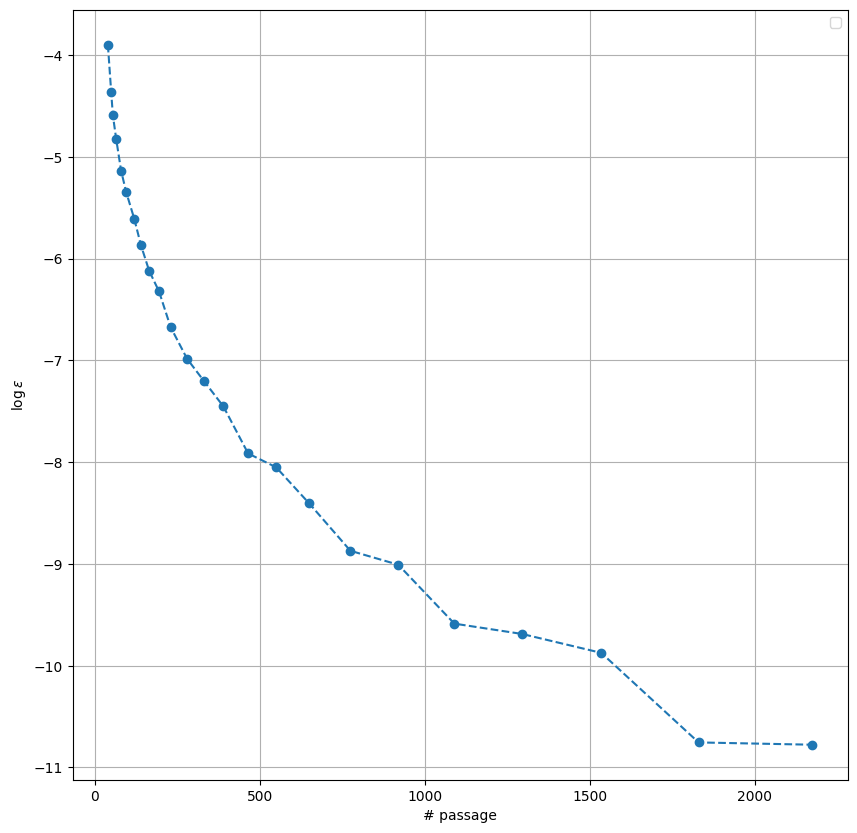

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_pass_list, np.log(sup_error_list), '--o')
plt.xlabel('# pass')
plt.ylabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Assume no access to true loss

In [100]:
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(3, 4, 0.25)

In [101]:
np.round(5 / np.sqrt(delta_list))

array([14., 15., 17., 18.])

In [102]:
total_pass_list = []
sup_error_list = []
grid_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid_1d = round(5 / np.sqrt(delta))
    num_grid_2d = [num_grid_1d, num_grid_1d]
    num_grid = num_grid_1d**2
    epochs = round(6 * np.log(1/delta))

    # start_time = time.time()
    total_pass, hyper_params, intercepts, weights, grid_pass_error = naive_grid_search_2d(lam_min_2d=lam_min_2d, lam_max_2d=lam_max_2d,
                                num_grid_2d=num_grid_2d, epochs=epochs, loss_fn=loss_fn,
                                trainDataLoader=GD_data_loader, data_input_dim=input_dim,
                                lr=lr, weighted_avg=False, testDataLoader=test_data_loader,
                                oracle=False, true_loss_list=true_losses,
                                check_frequency=1, device=device)

    # end_time = time.time()
    # execution_time = end_time - start_time

    total_pass_list.append(total_pass)

    # solution path error
    sup_error = get_sup_error_2d(lam_min_2d, lam_max_2d, true_losses, intercepts,
                                  weights, np.array(hyper_params), test_data_loader, loss_fn, device)

    sup_error_list.append(sup_error)
    grid_error_list.append(grid_pass_error)
    # print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")
    print(f"grid #: {num_grid}\t total iteration #: {total_pass}\t sup error: {sup_error}\t grid error: {grid_pass_error}")

total_pass_list = np.array(total_pass_list)
sup_error_list = np.array(sup_error_list)
grid_error_list = np.array(grid_error_list)

grid #: 196	 total iteration #: 2352	 sup error: 0.5882568955421448	 grid error: 0.08065319061279297
grid #: 225	 total iteration #: 3150	 sup error: 0.5516641736030579	 grid error: 0.05657672882080078
grid #: 289	 total iteration #: 4335	 sup error: 0.5334780216217041	 grid error: 0.04759502410888672
grid #: 324	 total iteration #: 5184	 sup error: 0.5153507590293884	 grid error: 0.040439605712890625


In [ ]:
df = pd.DataFrame(np.column_stack((total_pass_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact.csv')

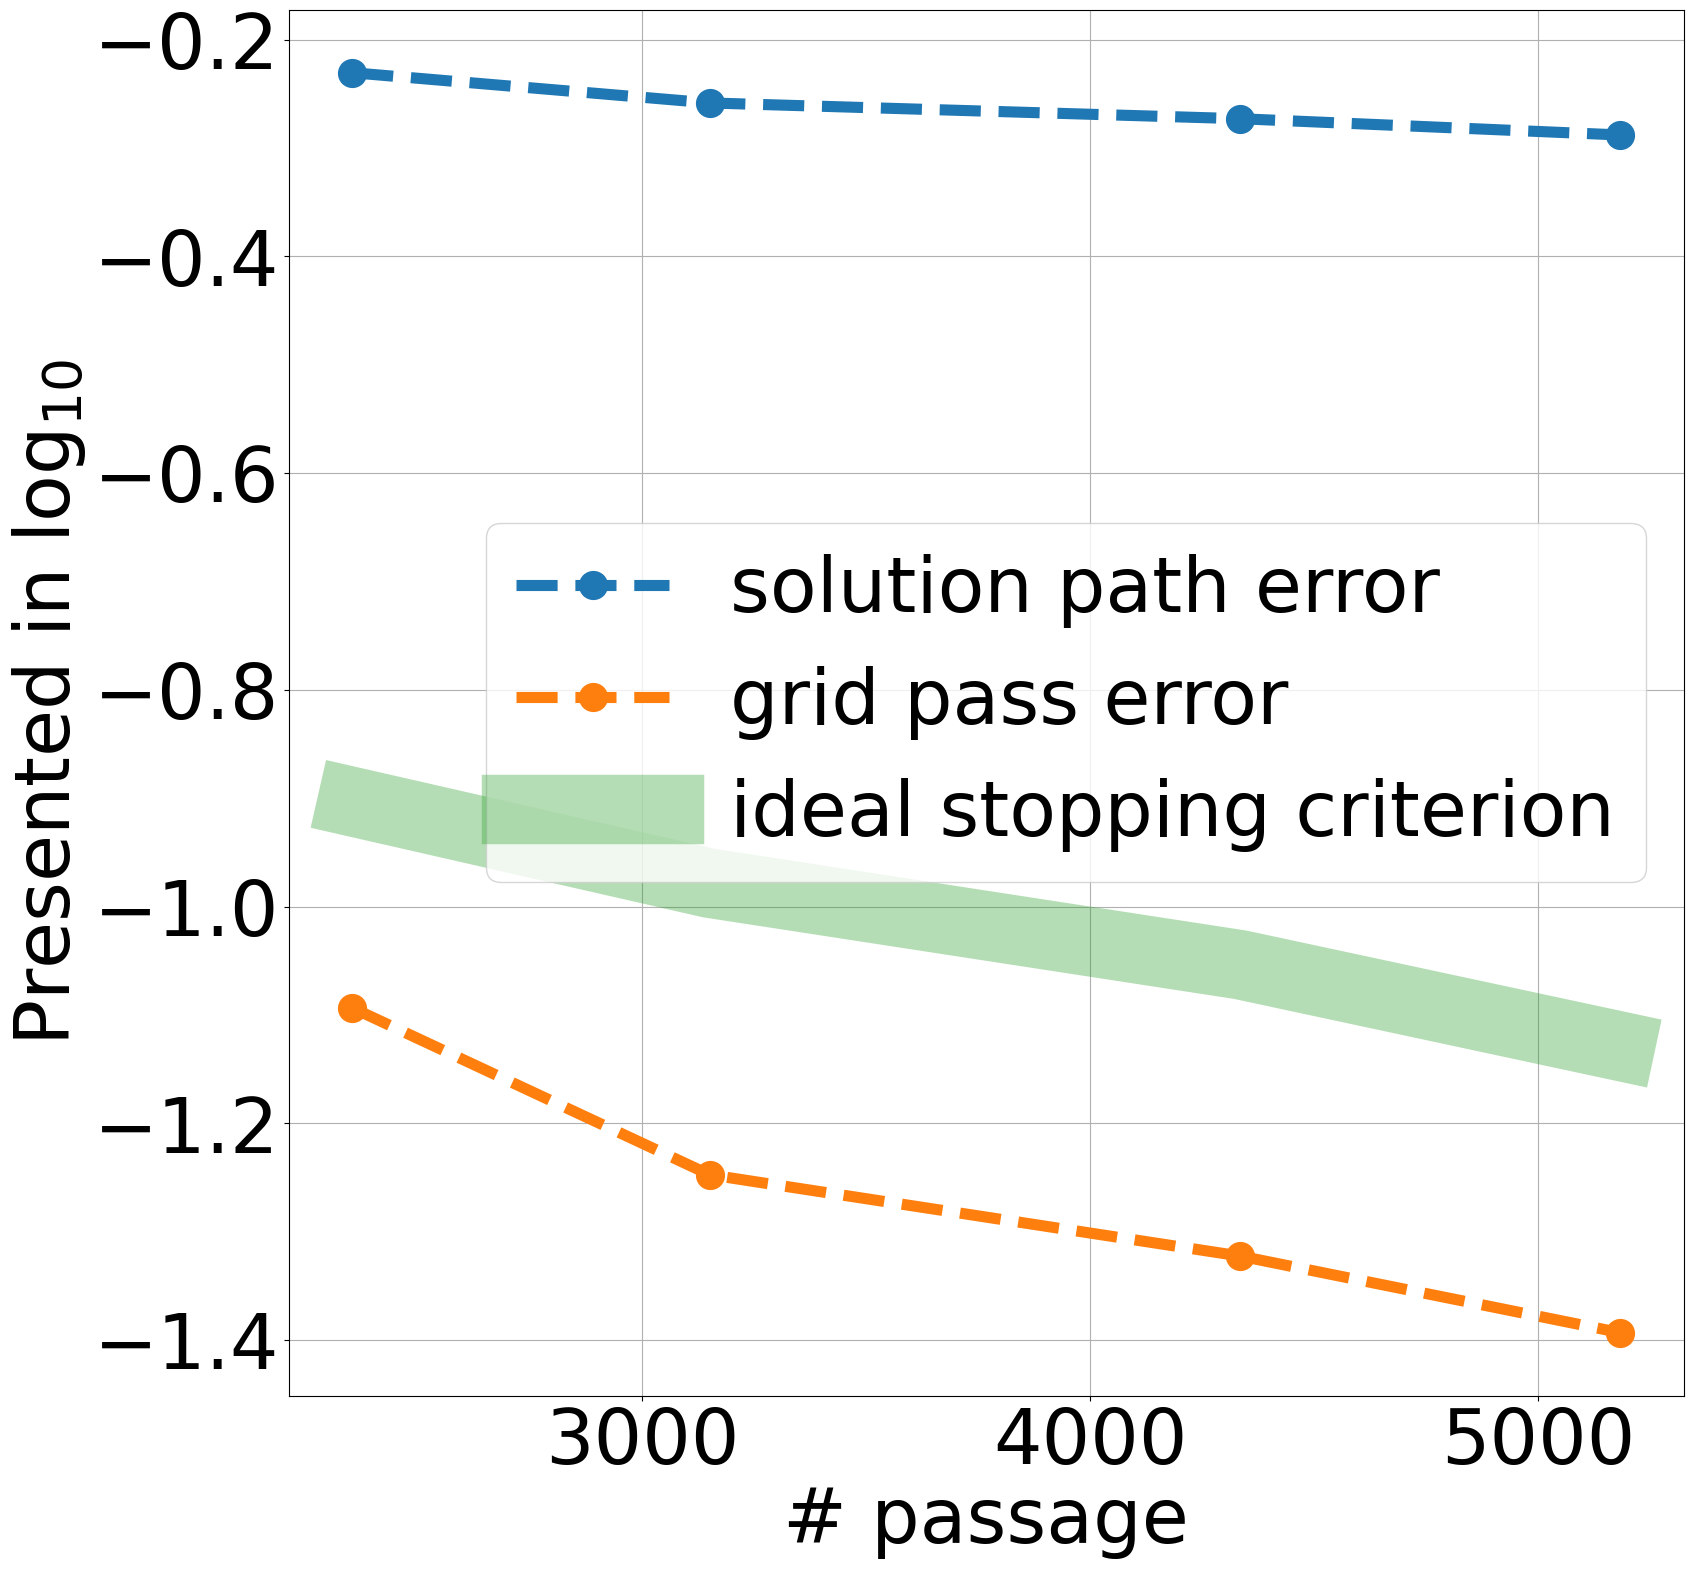

In [103]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(total_pass_list, np.log10(sup_error_list), '--o', linewidth=8, markersize=20, label="solution path error")
plt.plot(total_pass_list, np.log10(grid_error_list), '--o', linewidth=8, markersize=20, label="grid pass error")
plt.plot(total_pass_list, np.log10(delta_list), '-', linewidth=50, label="ideal stopping criterion", alpha=0.35)

# Set global font size
mpl.rcParams['font.size'] = 55

font_size = 55
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

plt.xlabel('# passage', fontsize=font_size)
plt.ylabel('Presented in $\\log_{10}$', fontsize=font_size)
plt.legend()
plt.grid(True)
plt.savefig("NGS_stopping_criterion_exact.png")